# Load and preprocess images

In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [ ]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)
data_dir = pathlib.Path(data_dir)

228827136/228813984 [==============================] - 2s 0us/step


In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


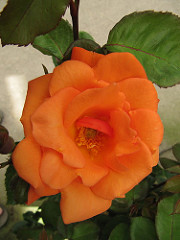

In [ ]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(180,180),
    batch_size=32
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(180, 180),
  batch_size=32)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


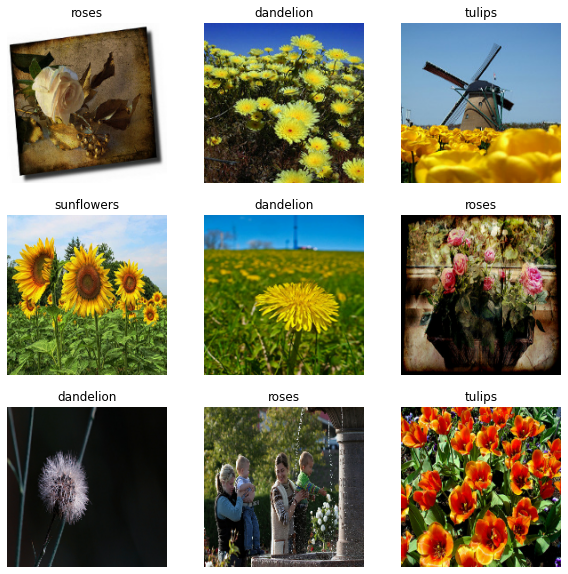

In [ ]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

데이터 표준화

In [ ]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


성능을 위한 데이터셋

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
num_classes = 5

model = tf.keras.Sequential([
                             tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
                             tf.keras.layers.Conv2D(32, 3, activation='relu'),
                             tf.keras.layers.MaxPooling2D(),
                             tf.keras.layers.Conv2D(32, 3, activation='relu'),
                             tf.keras.layers.MaxPooling2D(),
                             tf.keras.layers.Conv2D(32, 3, activation='relu'),
                             tf.keras.layers.MaxPooling2D(),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(129, activation='relu'),
                             tf.keras.layers.Dense(num_classes)])

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=10
)

Epoch 1/10
92/92 [==============================] - 5s 48ms/step - loss: 1.3281 - accuracy: 0.4213 - val_loss: 1.0610 - val_accuracy: 0.5395
Epoch 2/10
92/92 [==============================] - 4s 45ms/step - loss: 1.0114 - accuracy: 0.5984 - val_loss: 0.9844 - val_accuracy: 0.6104
Epoch 3/10
92/92 [==============================] - 4s 45ms/step - loss: 0.8353 - accuracy: 0.6853 - val_loss: 0.9104 - val_accuracy: 0.6580
Epoch 4/10
92/92 [==============================] - 4s 45ms/step - loss: 0.6628 - accuracy: 0.7493 - val_loss: 1.0650 - val_accuracy: 0.6267
Epoch 5/10
92/92 [==============================] - 4s 45ms/step - loss: 0.5172 - accuracy: 0.8147 - val_loss: 1.2516 - val_accuracy: 0.6172
Epoch 6/10
92/92 [==============================] - 4s 45ms/step - loss: 0.3890 - accuracy: 0.8617 - val_loss: 1.2569 - val_accuracy: 0.6471
Epoch 7/10
92/92 [==============================] - 4s 45ms/step - loss: 0.3338 - accuracy: 0.8842 - val_loss: 1.2389 - val_accuracy: 0.6540
Epoch 8/10
92

In [ ]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [ ]:
for f in list_ds.take(5):
  print(f.numpy())

b'/root/.keras/datasets/flower_photos/sunflowers/8929274876_17efc1774a_n.jpg'
b'/root/.keras/datasets/flower_photos/daisy/17357636476_1953c07aa4_n.jpg'
b'/root/.keras/datasets/flower_photos/daisy/6208851904_9d916ebb32_n.jpg'
b'/root/.keras/datasets/flower_photos/tulips/13910131718_731353d84c_n.jpg'
b'/root/.keras/datasets/flower_photos/sunflowers/6074427492_1b5bab7848_n.jpg'


In [ ]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != 'LICENSE.txt']))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [ ]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size
                      )

In [ ]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


In [ ]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  one_hot = parts[-2] == class_names
  return tf.argmax(one_hot)

In [ ]:
def decode_img(img):
  img = tf.io.decode_jpeg(img, channels=3)
  return tf.image.resize(img, [180,180])

In [ ]:
def preprocess_path(file_path):
  label = get_label(file_path)
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [ ]:
train_ds = train_ds.map(preprocess_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(preprocess_path, num_parallel_calls=AUTOTUNE)

In [ ]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  0


In [ ]:
train_ds.cache()

<CacheDataset shapes: ((180, 180, 3), ()), types: (tf.float32, tf.int64)>

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size = 1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

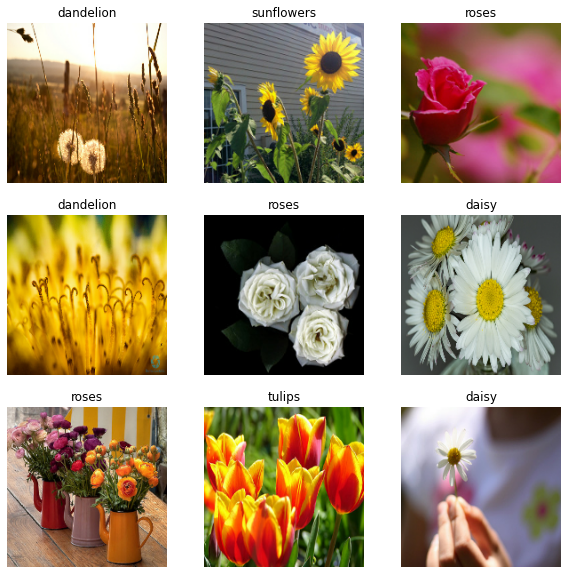

In [ ]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize = (10,10))
for i in range(9):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [ ]:
model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
92/92 [==============================] - 10s 84ms/step - loss: 0.3855 - accuracy: 0.8873 - val_loss: 0.3868 - val_accuracy: 0.8815
Epoch 2/10
92/92 [==============================] - 4s 48ms/step - loss: 0.1546 - accuracy: 0.9540 - val_loss: 0.3324 - val_accuracy: 0.9060
Epoch 3/10
92/92 [==============================] - 4s 48ms/step - loss: 0.0640 - accuracy: 0.9843 - val_loss: 0.3930 - val_accuracy: 0.9046
Epoch 4/10
92/92 [==============================] - 4s 48ms/step - loss: 0.0310 - accuracy: 0.9932 - val_loss: 0.3968 - val_accuracy: 0.9142
Epoch 5/10
92/92 [==============================] - 4s 48ms/step - loss: 0.0124 - accuracy: 0.9976 - val_loss: 0.4732 - val_accuracy: 0.9155
Epoch 6/10
92/92 [==============================] - 4s 48ms/step - loss: 0.0092 - accuracy: 0.9986 - val_loss: 0.4527 - val_accuracy: 0.9183
Epoch 7/10
92/92 [==============================] - 4s 48ms/step - loss: 0.0034 - accuracy: 0.9997 - val_loss: 0.4813 - val_accuracy: 0.9223
Epoch 8/10
9

In [ ]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]


Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [ ]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


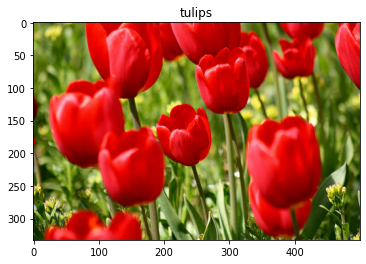

In [ ]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [ ]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)